# GR5243 Group Project 1
##### Xingchen Ji, Yuting Wang, Hongyi Xu, and Jiacan Zhou

### Part 1. Library Importing and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
eta = pd.read_csv("../Data/RTA.csv")

### Part 2. Explanatory Data Analysis
#### (a) Response Variable

[Text(0.5, 1.0, 'Histogram of Accident Severity'),
 Text(0.5, 0, 'Accident Severity')]

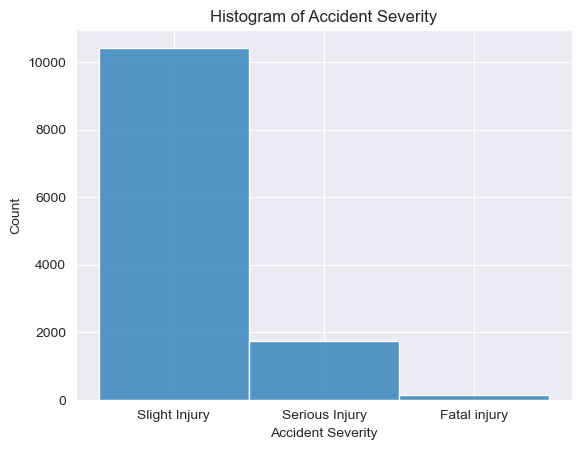

In [3]:
eta["Accident_severity"].value_counts()
sns.histplot(eta["Accident_severity"]).set(title = "Histogram of Accident Severity", xlabel = "Accident Severity")

#### (b) Data Cleaning and Feature Selection

In [4]:
eta.drop(["Service_year_of_vehicle", "Defect_of_vehicle", "Work_of_casuality", "Fitness_of_casuality"], axis = 1, inplace = True)
eta.drop(["Time", "Weather_conditions", "Casualty_class", "Sex_of_casualty", "Age_band_of_casualty", "Casualty_severity"], axis = 1, inplace = True)

In [5]:
categorical = [col for col in eta.columns]
categorical.remove("Number_of_vehicles_involved")
categorical.remove("Number_of_casualties")
categorical.remove("Accident_severity")
numerical = ["Number_of_vehicles_involved", "Number_of_casualties"]

In [6]:
eta.dropna(subset = categorical, inplace = True)

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Importance'),
 Text(0, 0.5, 'Features')]

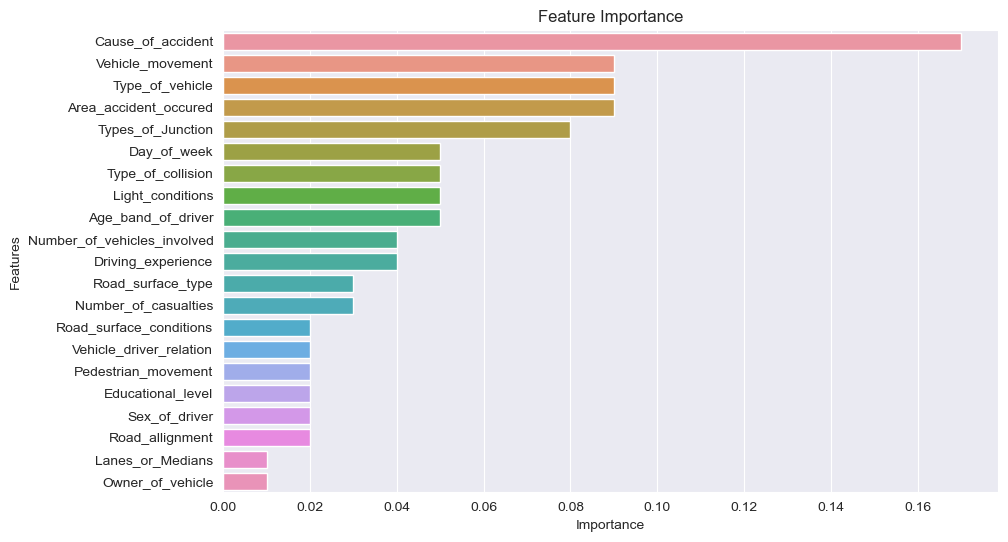

In [50]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
eta_fs = eta.copy()
eta_fs[numerical] = scaler.fit_transform(eta_fs[numerical])
y_ada = eta_fs["Accident_severity"]
X_ada = pd.get_dummies(eta_fs, columns = categorical, drop_first = True)
X_ada = X_ada.drop("Accident_severity", axis = 1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_ada, y_ada, test_size = 0.2, random_state = 233)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 100)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

feature_importance = np.mean([tree.feature_importances_ for tree in ada.estimators_], axis = 0)
feature_importance = pd.DataFrame(feature_importance, index = X_train.columns, columns = ["importance"]).sort_values("importance", ascending = False)
aggregated_features = {}
variable_index = categorical + numerical
for feature in variable_index:
    for i in range(len(feature_importance.index)):
        if feature in feature_importance.index[i]:
            if feature in aggregated_features:
                aggregated_features[feature] += feature_importance.iloc[i, 0]
            else:
                aggregated_features[feature] = feature_importance.iloc[i, 0]
        else:
            if feature not in aggregated_features:
                aggregated_features[feature] = 0
aggregated_features = pd.DataFrame.from_dict(aggregated_features, orient = "index", columns = ["importance"]).sort_values("importance", ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = aggregated_features["importance"], y = aggregated_features.index).set(title = "Feature Importance", xlabel = "Importance", ylabel = "Features");


In [13]:
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest
# from sklearn.preprocessing import LabelEncoder
# eta_chi = eta.copy()
# for col in categorical:
#     eta_chi[col] = LabelEncoder().fit_transform(eta_chi[col])
# x_kbest = eta_chi.drop("Accident_severity", inplace = False, axis = 1)
# y_kbest = eta_chi["Accident_severity"]
# p_value = chi2(x_kbest, y_kbest)
# p_value = pd.DataFrame({"features": x_kbest.columns, "p_value": p_value[1]}).sort_values(by = "p_value", ascending = False)
# p_value

,features,p_value
2,Sex_of_driver,9.545031e-01
3,Educational_level,9.215860e-01
19,Pedestrian_movement,8.944739e-01
10,Road_allignment,8.699458e-01
11,Types_of_Junction,7.416229e-01
7,Owner_of_vehicle,5.527546e-01
20,Cause_of_accident,5.422320e-01
18,Vehicle_movement,4.428975e-01
13,Road_surface_conditions,4.216265e-01
0,Day_of_week,2.897207e-01


In [14]:
# chi2_selector = SelectKBest(chi2, k = 20)
# chi2_selector.fit(x_kbest, y_kbest)
# chi2_support = chi2_selector.get_support()
# chi2_feature = x_kbest.loc[:, chi2_support].columns.tolist()
# chi2_feature

['Day_of_week',
 'Age_band_of_driver',
 'Educational_level',
 'Vehicle_driver_relation',
 'Driving_experience',
 'Type_of_vehicle',
 'Owner_of_vehicle',
 'Area_accident_occured',
 'Lanes_or_Medians',
 'Road_allignment',
 'Types_of_Junction',
 'Road_surface_type',
 'Road_surface_conditions',
 'Light_conditions',
 'Type_of_collision',
 'Number_of_vehicles_involved',
 'Number_of_casualties',
 'Vehicle_movement',
 'Pedestrian_movement',
 'Cause_of_accident']

#### (c) Preprocessing Dataset for ML Models

In [15]:
eta_new = eta[chi2_feature]
eta_new.head()

,Day_of_week,Age_band_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Area_accident_occured,Lanes_or_Medians,Road_allignment,Types_of_Junction,Road_surface_type,Road_surface_conditions,Light_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Pedestrian_movement,Cause_of_accident
1,Monday,31-50,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,Office areas,Undivided Two way,Tangent road with flat terrain,No junction,Asphalt roads,Dry,Daylight,Vehicle with vehicle collision,2,2,Going straight,Not a Pedestrian,Overtaking
3,Sunday,18-30,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,Office areas,other,Tangent road with mild grade and flat terrain,Y Shape,Earth roads,Dry,Darkness - lights lit,Vehicle with vehicle collision,2,2,Going straight,Not a Pedestrian,Changing lane to the right
7,Friday,18-30,Junior high school,Employee,2-5yr,Automobile,Governmental,Residential areas,other,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Daylight,Vehicle with vehicle collision,2,1,U-Turn,Not a Pedestrian,No priority to vehicle
8,Friday,18-30,Junior high school,Employee,Above 10yr,Lorry (41?100Q),Owner,Industrial areas,other,Tangent road with flat terrain,Y Shape,Earth roads,Dry,Daylight,Collision with roadside-parked vehicles,2,1,Going straight,Crossing from driver's nearside,Changing lane to the right
9,Friday,18-30,Junior high school,Employee,1-2yr,Automobile,Owner,Residential areas,Undivided Two way,Tangent road with flat terrain,Y Shape,Asphalt roads,Dry,Daylight,Collision with roadside-parked vehicles,2,1,U-Turn,Not a Pedestrian,Moving Backward


In [17]:
categorical_new = [col for col in eta_new.columns]
categorical_new.remove("Number_of_vehicles_involved")
categorical_new.remove("Number_of_casualties")
numerical_new = ["Number_of_vehicles_involved", "Number_of_casualties"]

In [18]:
eta_new[numerical_new] = scaler.fit_transform(eta_new[numerical_new])
X = pd.get_dummies(eta_new, columns = categorical_new, drop_first = True)
y = eta["Accident_severity"]

C:\Users\26447\AppData\Local\Temp\ipykernel_19780\2399200865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eta_new[numerical_new] = scaler.fit_transform(eta_new[numerical_new])


,Number_of_vehicles_involved,Number_of_casualties,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Age_band_of_driver_31-50,Age_band_of_driver_Over 51,...,Cause_of_accident_No distancing,Cause_of_accident_No priority to pedestrian,Cause_of_accident_No priority to vehicle,Cause_of_accident_Other,Cause_of_accident_Overloading,Cause_of_accident_Overspeed,Cause_of_accident_Overtaking,Cause_of_accident_Overturning,Cause_of_accident_Turnover,Cause_of_accident_Unknown
1,-0.055876,0.446105,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.055876,0.446105,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,-0.055876,-0.539413,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,-0.055876,-0.539413,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,-0.055876,-0.539413,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### (d) Synthetic Minority Oversampling Technique

In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
y_smote.value_counts()

Slight Injury     7169
Serious Injury    7169
Fatal injury      7169
Name: Accident_severity, dtype: int64

#### (e) Data Spliting

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 233)

### Part 3. Model Selection
#### (a) SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)
Accuracy score:  0.9239113590578025
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.99      0.99      0.99      2169
Serious Injury       0.93      0.85      0.89      2164
 Slight Injury       0.86      0.93      0.89      2120

      accuracy                           0.92      6453
     macro avg       0.93      0.92      0.92      6453
  weighted avg       0.93      0.92      0.92      6453



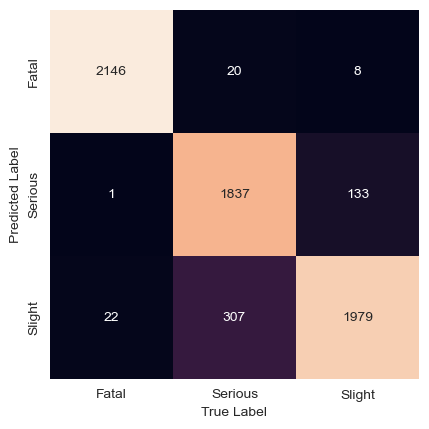

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
param_svc = {"C": [0.1, 1, 10, 100], "gamma": [1, 0.1, 0.01, 0.001], "kernel": ["rbf", "linear", "poly", "sigmoid"], "degree": [1, 2, 3, 4]}
svc = GridSearchCV(SVC(), param_svc, refit = True, verbose = 3, n_jobs = 12)
svc.fit(X_train, y_train)
print(svc.best_params_)
print(svc.best_estimator_)
y_pred = svc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True Label")
plt.ylabel("Predicted Label");

#### (b) Random Forest

Fitting 5 folds for each of 35 candidates, totalling 175 fits
{'max_depth': 15, 'n_estimators': 400}
RandomForestClassifier(max_depth=15, n_estimators=400)
Accuracy score:  0.9057802572446924
Classification report:                  precision    recall  f1-score   support

  Fatal injury       0.94      0.98      0.96      2169
Serious Injury       0.90      0.83      0.86      2164
 Slight Injury       0.87      0.91      0.89      2120

      accuracy                           0.91      6453
     macro avg       0.91      0.91      0.90      6453
  weighted avg       0.91      0.91      0.90      6453



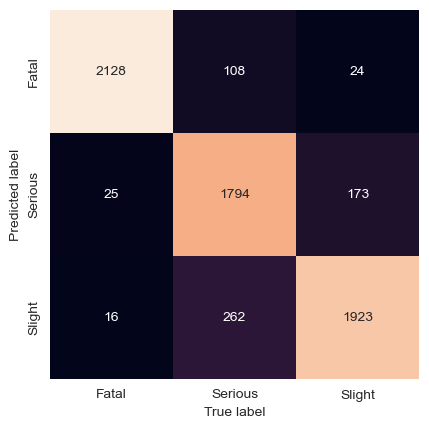

In [25]:
from sklearn.ensemble import RandomForestClassifier
param_rfc = {"n_estimators": [100, 200, 300, 400, 500], "max_depth": [3, 5, 7, 9, 11, 13, 15], "min_samples_split": [2, 4, 6, 8, 10], "min_samples_leaf": [1, 2, 3, 4, 5]}
rfc = GridSearchCV(RandomForestClassifier(), param_rfc, refit = True, verbose = 3, n_jobs = 12)
rfc.fit(X_train, y_train)
print(rfc.best_params_)
print(rfc.best_estimator_)
y_pred = rfc.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True label")
plt.ylabel("Predicted label");

#### (c) Multi-layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
param_mlp = {"hidden_layer_sizes": [(100, 100, 100), (100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], "activation": ["relu", "logistic"], "solver": ["adam", "sgd"], "alpha": [0.0001, 0.05], "learning_rate": ["constant", "adaptive"]}
mlp = GridSearchCV(MLPClassifier(), param_mlp, refit = True, verbose = 3, n_jobs = 12)
mlp.fit(X_train, y_train)
print(mlp.best_params_)
print(mlp.best_estimator_)
y_pred = mlp.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, y_pred))
print("Classification report: ", classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square = True, annot = True, fmt = "d", cbar = False, xticklabels = ["Fatal", "Serious", "Slight"], yticklabels = ["Fatal", "Serious", "Slight"])
plt.xlabel("True label")
plt.ylabel("Predicted label");

#### (d)

### Part 4. Model Comparison

In [26]:
models = pd.DataFrame({
    "Model": ["Support Vector Machine", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, svc.predict(X_test)), accuracy_score(y_test, rfc.predict(X_test))]})
models.sort_values(by = "Accuracy", ascending = False)

,Model,Accuracy
1,Support Vector Machine,0.923911
3,Random Forest,0.905780
2,Decision Tree,0.818534
0,Naive Bayes,0.514644


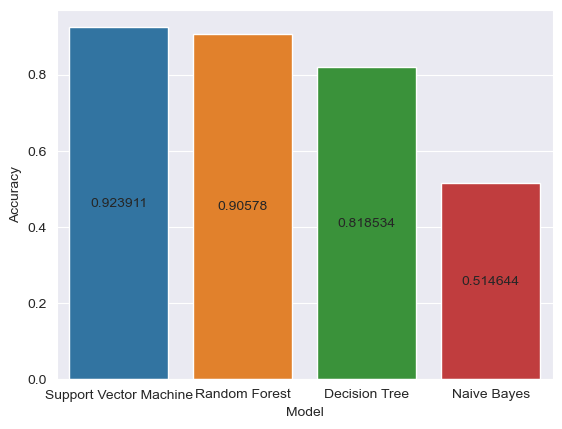

In [27]:
ax = sns.barplot(x = "Model", y = "Accuracy", data = models.sort_values(by = "Accuracy", ascending = False))
for acc in ax.containers:
    ax.bar_label(acc, label_type = "center");